In [1]:
import pandas as pd

sen_df: pd.DataFrame = pd.read_csv('/media/ponbac/BigHDD/ethereum/blacklist/seniority/seniority-tornado-result.csv', index_col=0)

In [3]:
from typing import Optional
import numpy as np

from tqdm import tqdm
from pprint import pprint
from db.mongo.database import IndagoSession
from db.mongo.schemas import DARAddressMapping, DARGraph

# MONGO
db = IndagoSession
dar_collection = db['dar']
dar_map_collection = db['dar_map']


def filter_exchange_nodes(nodes, edges) -> list[str]:
    '''
    Calculates non-exchange nodes from graph data.
    '''
    non_exchange_nodes = []
    for edge in edges:
        # print(edge)
        non_exchange_nodes.append(nodes[edge[0]])

    return set(non_exchange_nodes)


async def process_graphs(batch_size: int = 10000, max_graphs: Optional[int] = None):
    '''
    Prints a bunch of statistics about the number of nodes in the DAR graphs.

    returns: numpy.array with the number of nodes in each graph
    '''
    n_graphs = await dar_collection.count_documents({})
    print(f'INFO: {n_graphs:,} DAR graphs in collection')
    if max_graphs is None:
        max_graphs = n_graphs

    node_counts = []
    graphs_with_seniority = []
    total_nodes_in_seniority = 0

    i = 0
    print(
        f'INFO: Fetching {max_graphs:,} graphs, batch_size={batch_size:,}...')
    pbar = tqdm(total=max_graphs)
    while i * batch_size < max_graphs + batch_size:
        cursor = dar_collection.find()
        cursor.skip(i * batch_size)
        for graph in await cursor.to_list(length=batch_size):
            n_nodes = len(graph['nodes'])
            node_counts.append(n_nodes)

            nodes_in_seniority = 0
            for address in filter_exchange_nodes(graph['nodes'], graph['edges']):
                try:
                    row = sen_df.loc[address]
                    #print(f'{row}')
                    if row['taint'] > 0:
                        nodes_in_seniority += 1
                        if nodes_in_seniority == 1:
                            graphs_with_seniority.append(graph)
                    del row
                except KeyError:
                    pass
            total_nodes_in_seniority += nodes_in_seniority

        pbar.update(batch_size)
        i += 1
    pbar.close()

    print(f'DONE: {sum(node_counts):,} total nodes (addresses)')
    print(f'STATS: average={(np.mean(node_counts)):.2f} nodes')
    print(f'STATS: median={(np.median(node_counts)):.2f} nodes')
    print(f'STATS: min={(np.min(node_counts))}')
    print(f'STATS: max={(np.max(node_counts)):,}')
    print(f'STATS: standard deviation={(np.std(node_counts)):.2f}')
    print(f'STATS: variance={(np.var(node_counts)):.2f}')
    print('\n---SENIORITY (TORNADO)---')
    print(
        f'STATS: nodes cross found={total_nodes_in_seniority:,}, percentage of total={(total_nodes_in_seniority / sum(node_counts) * 100):.2f}%')
    print(
        f'STATS: graphs with >0 nodes in seniority={len(graphs_with_seniority):,}, percentage of total={(len(graphs_with_seniority) / n_graphs * 100):.2f}%')

    return np.array(node_counts), graphs_with_seniority

node_counts, sen_graphs = await process_graphs(batch_size=50000, max_graphs=None)
# del sen_df

INFO: 965,652 DAR graphs in collection
INFO: Fetching 965,652 graphs, batch_size=50,000...


1050000it [01:36, 10929.61it/s]                           


DONE: 5,361,931 total nodes (addresses)
STATS: average=5.55 nodes
STATS: median=4.00 nodes
STATS: min=3
STATS: max=27,420
STATS: standard deviation=39.00
STATS: variance=1521.16

---SENIORITY (TORNADO)---
STATS: nodes cross found=342,981, percentage of total=6.40%
STATS: graphs with >0 nodes in seniority=238,536, percentage of total=24.70%


Text(0.5, 1.0, 'Distribution of number of nodes in DAR graphs')

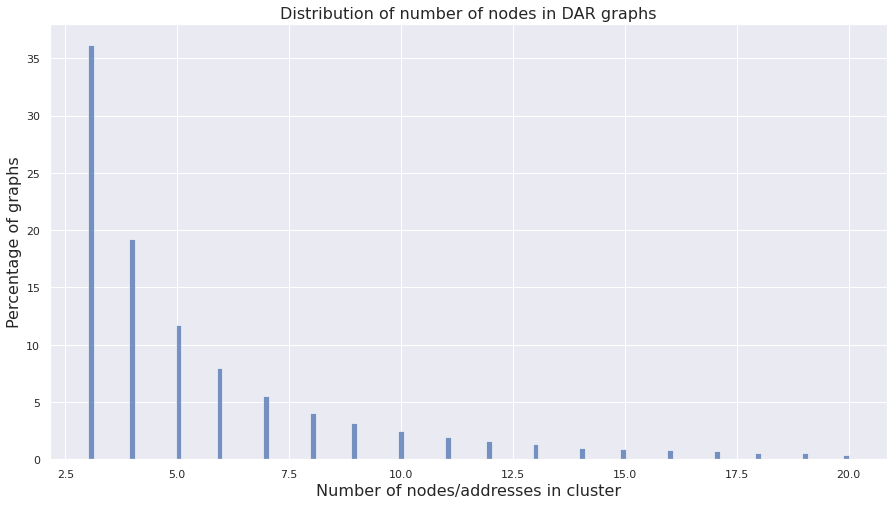

In [8]:
import seaborn as sns
import pandas as pd
import numpy as np

def reject_outliers(data, n_deviations=0.3):
    mean = np.mean(data)
    standard_deviation = np.std(data)
    distance_from_mean = abs(data - mean)
    not_outlier = distance_from_mean < n_deviations * standard_deviation
    return data[not_outlier]

sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
p = sns.histplot(data=reject_outliers(node_counts[:100000]), stat='percent')
p.set_xlabel('Number of nodes/addresses in cluster', fontsize=16)
p.set_ylabel('Percentage of graphs', fontsize=16)
p.set_title('Distribution of number of nodes in DAR graphs', fontsize=16)


In [9]:
flagged_counts = []
total_counts = []
for graph in tqdm(sen_graphs):
    flagged = 0
    total = 0
    for address in filter_exchange_nodes(graph['nodes'], graph['edges']):
        total += 1
        try:
            row = sen_df.loc[address]
            flagged += 1
            del row
        except KeyError:
            pass
    flagged_counts.append(flagged)
    total_counts.append(total)

avg_flagged = np.mean(flagged_counts)
avg_total = np.mean(total_counts)

print(f'STATS: average flagged user nodes={avg_flagged:.2f} nodes')
print(f'STATS: average total user nodes={avg_total:.2f} nodes')
print(f'STATS: num clusters with a single flagged node={flagged_counts.count(1):,}')

100%|██████████| 238536/238536 [00:19<00:00, 12010.62it/s]

STATS: average flagged user nodes=1.44 nodes
STATS: average total user nodes=2.74 nodes
STATS: num clusters with a single flagged node=180,645


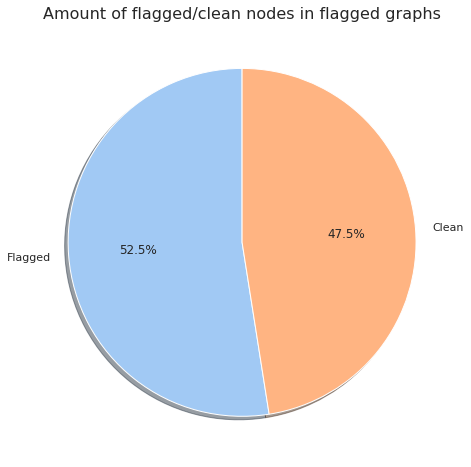

In [10]:
import matplotlib.pyplot as plt

data = [sum(flagged_counts), sum(total_counts) - sum(flagged_counts)]
labels = ['Flagged', 'Clean']
colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Amount of flagged/clean nodes in flagged graphs', fontsize=16)
plt.show()

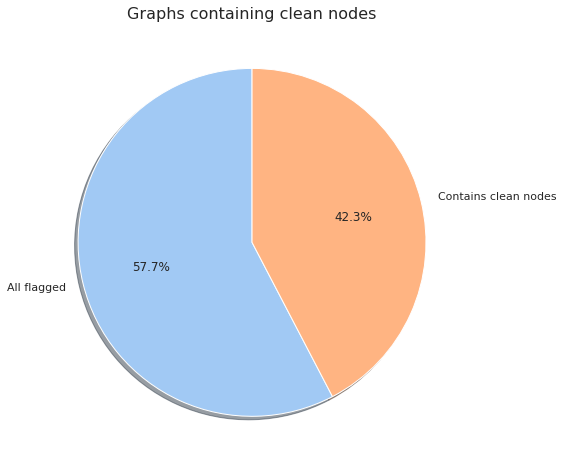

In [11]:
n_unflagged = []
for i, n in enumerate(flagged_counts):
    n_unflagged.append(total_counts[i] - n)
clusters_with_clean = list(filter(lambda x: x > 0, n_unflagged))

data = [len(flagged_counts) - len(clusters_with_clean), len(clusters_with_clean)]
labels = ['All flagged', 'Contains clean nodes']
colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Graphs containing clean nodes', fontsize=16)
plt.show()